## Setup Environment

In [ ]:
! pip install transformers
! pip install pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 486.1/486.1 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.2/302.2 kB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 58.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 160.5/160.5 kB 23.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.0/258.0 kB 31.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.9/81.9 kB 13.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 26.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 11.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.8/106.8 kB 13.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.7/80.7 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.8/21.8 MB 32.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 k

In [ ]:
import numpy as np
import pandas as pd
import pycaret
import transformers
from transformers import AutoModel, BertTokenizerFast
import matplotlib.pyplot as plt
# from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import torch
import torch.nn as nn
# specify GPU
device = torch.device("cuda")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/Project11_FakeNewsDetection



/content/drive/MyDrive/Project11_FakeNewsDetection


## Load Dataset

In [ ]:
true_data = pd.read_csv('a1_True.csv')
fake_data = pd.read_csv('a2_Fake.csv')

true_data['Target'] = ['True']*len(true_data)
fake_data['Target'] = ['Fake']*len(fake_data)

label_map = {"Fake": 1, "True": 0}

true_data['label'] = true_data['Target'].replace(label_map)
fake_data['label'] = fake_data['Target'].replace(label_map)

data = pd.concat([true_data, fake_data]).sample(frac=1).reset_index(drop=True)


print(data.shape)
data.head()

(44898, 6)


,title,text,subject,date,Target,label
0,Russia says will target U.S.-backed fighters i...,MOSCOW/WASHINGTON (Reuters) - Russia warned th...,worldnews,"September 21, 2017",True,0
1,MERYL STREEP PROBABLY FORGOT The Time Obama Ac...,Streep s shameful attempt to paint Trump as a ...,left-news,"Jan 10, 2017",Fake,1
2,"Honduran candidate says Nasralla won, urges pr...","TEGUCIGALPA (Reuters) - Luis Zelaya, the third...",worldnews,"November 27, 2017",True,0
3,"Turkey says U.S. isolated on Jerusalem, issuin...",ANKARA (Reuters) - Turkey said on Wednesday th...,worldnews,"December 20, 2017",True,0
4,BRAVO! TED CRUZ To Introduce Bill To Help Trum...,Now one unlikely Senator is about to put forth...,politics,"Apr 25, 2017",Fake,1


In [ ]:
data.head()

,title,text,subject,date,Target,label
0,Russia says will target U.S.-backed fighters i...,MOSCOW/WASHINGTON (Reuters) - Russia warned th...,worldnews,"September 21, 2017",True,0
1,MERYL STREEP PROBABLY FORGOT The Time Obama Ac...,Streep s shameful attempt to paint Trump as a ...,left-news,"Jan 10, 2017",Fake,1
2,"Honduran candidate says Nasralla won, urges pr...","TEGUCIGALPA (Reuters) - Luis Zelaya, the third...",worldnews,"November 27, 2017",True,0
3,"Turkey says U.S. isolated on Jerusalem, issuin...",ANKARA (Reuters) - Turkey said on Wednesday th...,worldnews,"December 20, 2017",True,0
4,BRAVO! TED CRUZ To Introduce Bill To Help Trum...,Now one unlikely Senator is about to put forth...,politics,"Apr 25, 2017",Fake,1


([<matplotlib.patches.Wedge at 0x7adf66b80970>,
 [Text(-1.1968727067385088, -0.0865778485782335, 'Fake'),
  Text(1.1968726986325005, 0.08657796063754254, 'True')],
 [Text(-0.6981757455974634, -0.05050374500396954, '52.3%'),
  Text(0.6981757408689586, 0.05050381037189981, '47.7%')])

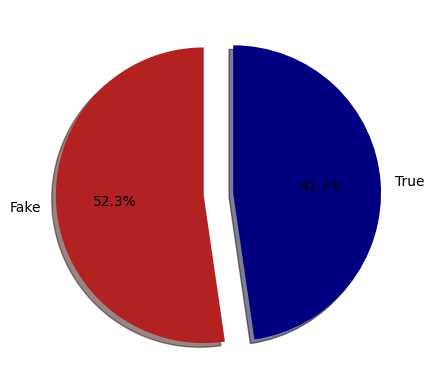

In [ ]:
label_size = [data['label'].sum(),len(data['label'])-data['label'].sum()]
plt.pie(label_size,explode=[0.1,0.1],colors=['firebrick','navy'],startangle=90,shadow=True,labels=['Fake','True'],autopct='%1.1f%%')

## Train-test-split

In [ ]:
train_text, temp_text, train_labels, temp_labels = train_test_split(data['title'], data['label'],
                                                                    random_state=2018,
                                                                    test_size=0.3,
                                                                    stratify=data['Target'])
val_text, test_text, val_labels, test_labels = train_test_split(temp_text, temp_labels,
                                                                random_state=2018,
                                                                test_size=0.5,
                                                                stratify=temp_labels)

## BERT Fine-tuning

### Load pretrained BERT Model

In [ ]:
bert = AutoModel.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

### Prepare Input Data

Text(0, 0.5, 'Number of texts')

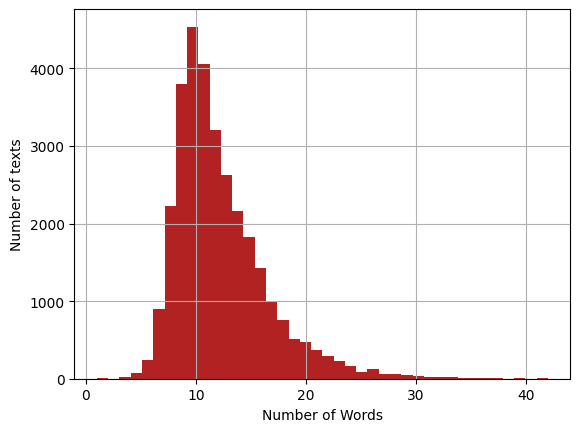

In [ ]:
seq_len = [len(title.split()) for title in train_text]

pd.Series(seq_len).hist(bins = 40,color='firebrick')
plt.xlabel('Number of Words')
plt.ylabel('Number of texts')

In [ ]:
sample_data = ["Build fake news model.",
               "Using bert."]                                         # sample data
tokenized_sample_data = tokenizer.batch_encode_plus(sample_data,
                                                    padding=True)     # encode text
print(tokenized_sample_data)



{'input_ids': [[101, 3857, 8275, 2739, 2944, 1012, 102], [101, 2478, 14324, 1012, 102, 0, 0]], 'token_type_ids': [[0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 0, 0]]}


In [ ]:
MAX_LENGHT = 15
tokens_train = tokenizer.batch_encode_plus(
    train_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
tokens_val = tokenizer.batch_encode_plus(
    val_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)
tokens_test = tokenizer.batch_encode_plus(
    test_text.tolist(),
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

In [ ]:
train_seq = torch.tensor(tokens_train['input_ids'])
train_mask = torch.tensor(tokens_train['attention_mask'])
train_y = torch.tensor(train_labels.tolist())

val_seq = torch.tensor(tokens_val['input_ids'])
val_mask = torch.tensor(tokens_val['attention_mask'])
val_y = torch.tensor(val_labels.tolist())

test_seq = torch.tensor(tokens_test['input_ids'])
test_mask = torch.tensor(tokens_test['attention_mask'])
test_y = torch.tensor(test_labels.tolist())

In [ ]:
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
batch_size = 32

train_data = TensorDataset(train_seq, train_mask, train_y)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_seq, val_mask, val_y)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler = val_sampler, batch_size=batch_size)


### Freeze Layers

In [ ]:
for param in bert.parameters():
    param.requires_grad = False

### Define Model Architecture

In [ ]:
class BERT_Arch(nn.Module):
    def __init__(self, bert):
      super(BERT_Arch, self).__init__()
      self.bert = bert
      self.dropout = nn.Dropout(0.1)
      self.relu =  nn.ReLU()
      self.fc1 = nn.Linear(768,512)
      self.fc2 = nn.Linear(512,2)
      self.softmax = nn.LogSoftmax(dim=1)
    def forward(self, sent_id, mask):
      cls_hs = self.bert(sent_id, attention_mask=mask)['pooler_output']

      x = self.fc1(cls_hs)
      x = self.relu(x)
      x = self.dropout(x)
      x = self.fc2(x)
      x = self.softmax(x)
      return x

model = BERT_Arch(bert)

from transformers import AdamW
optimizer = AdamW(model.parameters(),
                  lr = 1e-5)
cross_entropy  = nn.NLLLoss()

epochs = 2

### Define Train & Evaluate Function

In [ ]:
def train():
  model.train()
  total_loss, total_accuracy = 0, 0

  for step,batch in enumerate(train_dataloader):
    if step % 50 == 0 and not step == 0:
      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(train_dataloader)))
    batch = [r for r in batch]
    sent_id, mask, labels = batch
    model.zero_grad()
    preds = model(sent_id, mask)
    loss = cross_entropy(preds, labels)
    # loss = torch.nn.functional.nll_loss(preds, labels)
    total_loss = total_loss + loss.item()
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    preds=preds.detach().cpu().numpy()

  avg_loss = total_loss / len(train_dataloader)

  return avg_loss

def evaluate():
  print("\nEvaluating...")
  model.eval()
  total_loss, total_accuracy = 0, 0
  for step,batch in enumerate(val_dataloader):
    if step % 50 == 0 and not step == 0:


      print('  Batch {:>5,}  of  {:>5,}.'.format(step, len(val_dataloader)))

    batch = [t for t in batch]
    sent_id, mask, labels = batch
    with torch.no_grad():
      preds = model(sent_id, mask)
      loss = cross_entropy(preds,labels)
      total_loss = total_loss + loss.item()
      preds = preds.detach().cpu().numpy()
  avg_loss = total_loss / len(val_dataloader)
  return avg_loss

### Model training

In [ ]:
# Train and predict
best_valid_loss = float('inf')
train_losses=[]
valid_losses=[]

for epoch in range(epochs):
    print('\n Epoch {:} / {:}'.format(epoch + 1, epochs))
    train_loss = train()
    valid_loss = evaluate()
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'c2_new_model_weights.pt')
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)

    print(f'\nTraining Loss: {train_loss:.3f}')
    print(f'Validation Loss: {valid_loss:.3f}')


 Epoch 1 / 2
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  Batch   650  of    983.
  Batch   700  of    983.
  Batch   750  of    983.
  Batch   800  of    983.
  Batch   850  of    983.
  Batch   900  of    983.
  Batch   950  of    983.

Evaluating...
  Batch    50  of    211.
  Batch   100  of    211.
  Batch   150  of    211.
  Batch   200  of    211.

Training Loss: 0.558
Validation Loss: 0.483

 Epoch 2 / 2
  Batch    50  of    983.
  Batch   100  of    983.
  Batch   150  of    983.
  Batch   200  of    983.
  Batch   250  of    983.
  Batch   300  of    983.
  Batch   350  of    983.
  Batch   400  of    983.
  Batch   450  of    983.
  Batch   500  of    983.
  Batch   550  of    983.
  Batch   600  of    983.
  

### Model performance

In [ ]:

path = 'c2_new_model_weights.pt'
model.load_state_dict(torch.load(path))

<All keys matched successfully>

In [ ]:
with torch.no_grad():
  preds = model(test_seq, test_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
print(classification_report(test_y, preds))

              precision    recall  f1-score   support

           0       0.77      0.90      0.83      3212
           1       0.89      0.76      0.82      3523

    accuracy                           0.83      6735
   macro avg       0.83      0.83      0.83      6735
weighted avg       0.84      0.83      0.83      6735



## Fake News Predictions

In [ ]:
unseen_news_text = ["Donald Trump Sends Out Embarrassing New Year’s Eve Message; This is Disturbing",
                    "WATCH: George W. Bush Calls Out Trump For Supporting White Supremacy",
                    "U.S. lawmakers question businessman at 2016 Trump Tower meeting: sources",
                    "Trump administration issues new rules on U.S. visa waivers"
                    ]

MAX_LENGHT = 15
tokens_unseen = tokenizer.batch_encode_plus(
    unseen_news_text,
    max_length = MAX_LENGHT,
    pad_to_max_length=True,
    truncation=True
)

unseen_seq = torch.tensor(tokens_unseen['input_ids'])
unseen_mask = torch.tensor(tokens_unseen['attention_mask'])

with torch.no_grad():
  preds = model(unseen_seq, unseen_mask)
  preds = preds.detach().cpu().numpy()

preds = np.argmax(preds, axis = 1)
preds

array([1, 0, 0, 0])